In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import glob
import math

In [2]:
CHAR_DICT=dict()
NO_DICT=dict()
for i in range(26):
    CHAR_DICT[chr(97+i)]=i
    NO_DICT[i]=chr(97+i)

In [3]:
print(CHAR_DICT,NO_DICT)

{'d': 3, 'k': 10, 'z': 25, 'v': 21, 's': 18, 'w': 22, 't': 19, 'n': 13, 'q': 16, 'c': 2, 'x': 23, 'o': 14, 'e': 4, 'r': 17, 'g': 6, 'f': 5, 'y': 24, 'a': 0, 'u': 20, 'l': 11, 'j': 9, 'i': 8, 'm': 12, 'b': 1, 'h': 7, 'p': 15} {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}


In [4]:
import math
def resize_image(image):
    height_inc=((28-image.shape[0])//2)
    width_inc=math.floor((28-image.shape[1])/2)
    #print(width_inc,image.shape[1])
    BLUE=[0,0,0]
    constant=cv2.copyMakeBorder(image,height_inc,height_inc,width_inc,width_inc,cv2.BORDER_ISOLATED,value=BLUE)
    
    if(constant.shape[1]<28):
        constant=resize_image(constant[:,:26])
    if(constant.shape[0]<28):
        constant=resize_image(constant[0:26,:])
    return constant

In [5]:
def prepare_labels():
    file=open('labels.txt','r')
    all_lines=file.readlines()
    characters=[]
    for i in range(0,len(all_lines),2):
        characters+=all_lines[i][:-1].split(' ')
    labels=[]
    #print(characters)
    for i in range(len(characters)-1):
        labels.append(CHAR_DICT[characters[i].lower()])
    #print(labels)
    return labels
def prepare_training_data():
    
    X_train=[]
    for i in range(260):
        image_name='./chars/image'
        image_name+=str(i)+'.jpg'
        #print(image_name)
        image=cv2.imread(image_name)
        
        image=resize_image(image)
        
        #print(image_name,image.shape)
        X_train.append(image)
    return X_train



In [6]:
X_train=prepare_training_data()
X_train=np.array(X_train)
y_train=prepare_labels()
x_valid=X_train[:52]
y_valid=y_train[:52]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


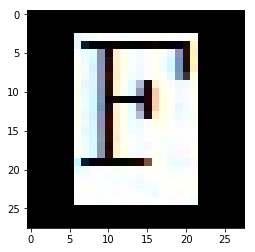

In [7]:
plt.imshow(X_train[5])
print(y_valid)

In [8]:
from tensorflow.contrib.layers import flatten
EPOCHS=100
BATCH_SIZE=50
def Model_Arch(x,prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    kernal1 = tf.Variable(tf.truncated_normal(shape = (3,3,3,6),mean = mu,stddev = sigma))
    bias1 = tf.Variable(tf.zeros(6))
    
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    #conv2d takes input,filter,strides,padding
    conv1 = tf.add(tf.nn.conv2d(x,kernal1,strides=[1,1,1,1],padding = 'VALID'),bias1)
    #adding bias 

    
    
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    
    
    
    conv1 = tf.nn.avg_pool(conv1,ksize = [1,2,2,1],strides = [1,2,2,1],padding = 'VALID')
    
    first_layer_output = conv1
    
   
    
    kernal2 = tf.Variable(tf.truncated_normal(shape = (3,3,6,16),mean = mu,stddev = sigma))
    
    bias2 = tf.Variable(tf.zeros(16))
    conv2 = tf.add(tf.nn.conv2d(first_layer_output,kernal2,strides=[1,2,2,1],padding = 'VALID'),bias2)
    
    
    
    
    
    # TODO: Activation.
    
    conv2 = tf.nn.relu(conv2)
    
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    
    second_layer_output = conv2
    #return second_layer_output
    flatted_input = flatten(second_layer_output)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    weight1  = tf.Variable(tf.truncated_normal(shape = (576,200),mean = mu,stddev = sigma))
    bias3 = tf.Variable(tf.zeros(200))
    
    output = tf.add(tf.matmul(flatted_input,weight1),bias3)
    # TODO: Activation.
    output = tf.nn.relu(output)
    output = tf.nn.dropout(output, prob)
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    weight2  = tf.Variable(tf.truncated_normal(shape = (200,100),mean = mu,stddev = sigma))
    bias4  = tf.Variable(tf.zeros(100))
    output2 = tf.add(tf.matmul(output,weight2),bias4)
    output2 = tf.nn.relu(output2)
    output2 = tf.nn.dropout(output2, prob)
    
    # TODO: Activation.

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
    weight3 = tf.Variable(tf.truncated_normal(shape=(100,26),mean = mu,stddev = sigma))
    bias5 = tf.Variable(tf.zeros(26))
    output3 = tf.add(tf.matmul(output2,weight3),bias5)
    logits = output3
    return logits

In [9]:
learning_rate=0.0001
x = tf.placeholder(tf.float32, (None,28, 28, 3))
prob=tf.placeholder(tf.float32)

logits=Model_Arch(x,prob)
y = tf.placeholder(tf.int32, (None))
one_hot_y=tf.one_hot(y,26)
entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss = tf.reduce_mean(entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss)


In [10]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate_model(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples



In [13]:
from sklearn.utils import shuffle
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,prob:0.7})
            
        validation_accuracy = evaluate_model(x_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './CharacterClassifier.ckpt')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.038

EPOCH 2 ...
Validation Accuracy = 0.000

EPOCH 3 ...
Validation Accuracy = 0.019

EPOCH 4 ...
Validation Accuracy = 0.019

EPOCH 5 ...
Validation Accuracy = 0.038

EPOCH 6 ...
Validation Accuracy = 0.038

EPOCH 7 ...
Validation Accuracy = 0.058

EPOCH 8 ...
Validation Accuracy = 0.096

EPOCH 9 ...
Validation Accuracy = 0.096

EPOCH 10 ...
Validation Accuracy = 0.096

EPOCH 11 ...
Validation Accuracy = 0.096

EPOCH 12 ...
Validation Accuracy = 0.096

EPOCH 13 ...
Validation Accuracy = 0.096

EPOCH 14 ...
Validation Accuracy = 0.115

EPOCH 15 ...
Validation Accuracy = 0.096

EPOCH 16 ...
Validation Accuracy = 0.096

EPOCH 17 ...
Validation Accuracy = 0.115

EPOCH 18 ...
Validation Accuracy = 0.115

EPOCH 19 ...
Validation Accuracy = 0.115

EPOCH 20 ...
Validation Accuracy = 0.154

EPOCH 21 ...
Validation Accuracy = 0.154

EPOCH 22 ...
Validation Accuracy = 0.173

EPOCH 23 ...
Validation Accuracy = 0.192

EPOCH 24 ...
Validation Accura

In [20]:
test_image=cv2.imread('./test/image0.jpg')
test_image=resize_image(test_image)
test_image=np.expand_dims(test_image,axis=0)
with tf.Session() as sess:
    
    new_saver = tf.train.import_meta_graph('CharacterClassifier.ckpt.meta')
    new_saver.restore(sess,tf.train.latest_checkpoint('.'))
    test_images_output = sess.run(tf.nn.softmax(logits), feed_dict={x: test_image,prob : 1.0})
print(test_images_output)

[[  1.30110851e-03   6.95755472e-03   3.52796726e-03   3.03880312e-03
    2.14705971e-04   1.93685270e-03   3.23269353e-03   1.09335117e-03
    7.77418783e-04   2.28812136e-02   2.81638175e-04   1.46831770e-03
    5.22610009e-01   2.97237956e-03   5.63653884e-03   1.04271842e-03
    1.18928691e-02   1.74361956e-03   1.32405999e-04   2.96122773e-04
    4.66513168e-03   2.12520421e-01   6.84143975e-02   2.95818760e-03
    2.44777370e-03   1.15955800e-01]]


In [21]:
print(NO_DICT[np.argmax(test_images_output)])

m
